# OnlineStats Integration

- OnlineStats is a Julia package for running statistical algorithms both online (one observation at a time) and in parallel.
- In this notebook we will go over how to run these calculations through JuliaDB.

First we'll load OnlineStats, JuliaDB and Plots (with GR backend)

In [1]:
using OnlineStats, JuliaDB, Plots
gr()

# print table rather than column summary
IndexedTables.set_show_compact!(false);

Now we'll see:
1. An Intro to OnlineStats
1. An Example Using OnlineStats with `partitionplot`, `reduce`, and `groupreduce` (all available for out-of-core processing!)
1. Mosaic Plots
1. Linear Regression
1. Approximate Solutions to Statistical Learning Models with `StatLearn`

# Intro to OnlineStats

### Every stat is a type

In [2]:
m = Mean()

Mean: n=0 | value=0.0

### Stats can be `fit!`-ted with more data

In [3]:
fit!(m, randn(100))

Mean: n=100 | value=0.139187

### Stats can be `merge!`-ed together

In [4]:
m2 = fit!(Mean(), randn(100))

merge!(m, m2)

Mean: n=200 | value=0.0827811

### `fit!`-ting and `merge!`-ing works quite well with JuliaDB

- JuliaDB can send stats to the worker processes and then merge them at the end.

<img src="https://user-images.githubusercontent.com/8075494/32748459-519986e8-c88a-11e7-89b3-80dedf7f261b.png" width=400>

# Example: Diamonds Dataset

- OnlineStats operations are available through `partitionplot`, `reduce` and `groupreduce`.
- Here we will take a look at a dataset about diamond quality.


- First let's examine the first few rows of the data:

In [5]:
;head diamonds.csv

"","carat","cut","color","clarity","depth","table","price","x","y","z"
"1",0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43
"2",0.21,"Premium","E","SI1",59.8,61,326,3.89,3.84,2.31
"3",0.23,"Good","E","VS1",56.9,65,327,4.05,4.07,2.31
"4",0.29,"Premium","I","VS2",62.4,58,334,4.2,4.23,2.63
"5",0.31,"Good","J","SI2",63.3,58,335,4.34,4.35,2.75
"6",0.24,"Very Good","J","VVS2",62.8,57,336,3.94,3.96,2.48
"7",0.24,"Very Good","I","VVS1",62.3,57,336,3.95,3.98,2.47
"8",0.26,"Very Good","H","SI1",61.9,55,337,4.07,4.11,2.53
"9",0.22,"Fair","E","VS2",65.1,61,337,3.87,3.78,2.49


- The first column is the row number, so we'll only load the other columns.  Here we sort the data by column 2, `:carat`.

In [6]:
using JuliaDB
t = loadtable("diamonds.csv", indexcols = [2], datacols = 3:11)

Table with 53940 rows, 10 columns:
carat  cut          color  clarity  depth  table  price  x      y      z
───────────────────────────────────────────────────────────────────────────
0.2    "Premium"    "E"    "SI2"    60.2   62.0   345    3.79   3.75   2.27
0.2    "Premium"    "E"    "VS2"    59.8   62.0   367    3.79   3.77   2.26
0.2    "Premium"    "E"    "VS2"    59.0   60.0   367    3.81   3.78   2.24
0.2    "Premium"    "E"    "VS2"    61.1   59.0   367    3.81   3.78   2.32
0.2    "Premium"    "E"    "VS2"    59.7   62.0   367    3.84   3.8    2.28
0.2    "Ideal"      "E"    "VS2"    59.7   55.0   367    3.86   3.84   2.3
0.2    "Premium"    "F"    "VS2"    62.6   59.0   367    3.73   3.71   2.33
0.2    "Ideal"      "D"    "VS2"    61.5   57.0   367    3.81   3.77   2.33
0.2    "Very Good"  "E"    "VS2"    63.4   59.0   367    3.74   3.71   2.36
0.2    "Ideal"      "E"    "VS2"    62.2   57.0   367    3.76   3.73   2.33
0.2    "Premium"    "D"    "VS2"    62.3   60.0   367    

# `partitionplot`

`partitionplot(table[, x], y; by, stat, nparts, dropmissing)`

- We introduced `partitionplot` in the previous notebook.  
- Here we'll go through some more advanced examples.
- If only one variable is provided, the x-axis will be the number of observations.  
- Note that `:carat` is our index variable and thus it is sorted:

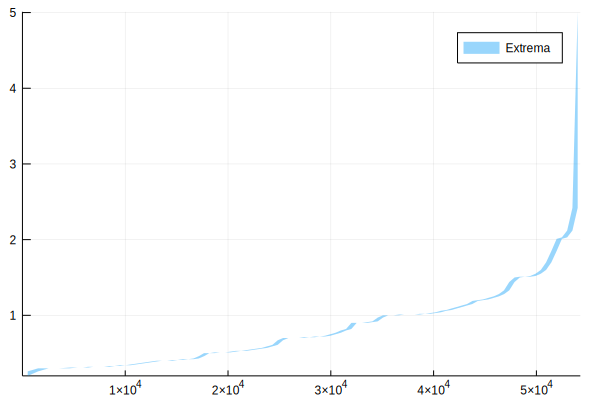

In [7]:
partitionplot(t, :carat)

- When we provide two variables, the summary of the `y` variable is plotted in each "section" of the `x` variable.  

- In this example, we'll use the Interact package to choose which statistic to summarize `y` with in the of plot `y = :price` vs. `x = :carat`:

INFO: Interact.jl: using new nbwidgetsextension protocol


Interact.Options{:ToggleButtons,OnlineStatsBase.OnlineStat{Number}}(1: "input" = Mean: n=0 | value=0.0 OnlineStatsBase.OnlineStat{Number} , "summarizer", Mean: n=0 | value=0.0, "Mean: n=0 | value=0.0", 1, Interact.OptionDict(DataStructures.OrderedDict{String,OnlineStatsBase.OnlineStat{Number}}("Mean: n=0 | value=0.0"=>Mean: n=0 | value=0.0,"Extrema: n=0 | value=(Inf, -Inf)"=>Extrema: n=0 | value=(Inf, -Inf),"Hist: AdaptiveBins"=>Hist: AdaptiveBins), Dict{OnlineStatsBase.OnlineStat{Number},String}(Pair{OnlineStatsBase.OnlineStat{Number},String}(Mean: n=0 | value=0.0, "Mean: n=0 | value=0.0"),Pair{OnlineStatsBase.OnlineStat{Number},String}(Hist: AdaptiveBins, "Hist: AdaptiveBins"),Pair{OnlineStatsBase.OnlineStat{Number},String}(Extrema: n=0 | value=(Inf, -Inf), "Extrema: n=0 | value=(Inf, -Inf)"))), Any[], Any[], true, "horizontal", true)

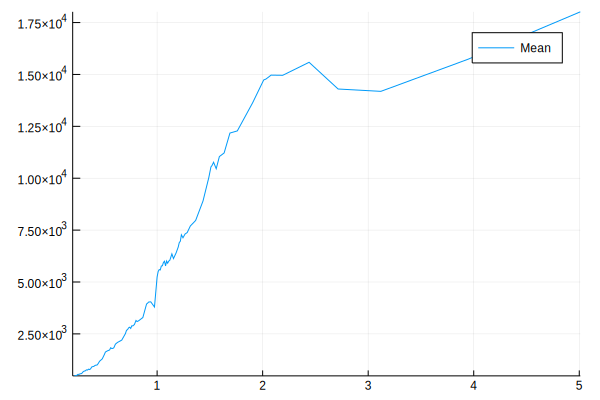

In [8]:
import Interact

Interact.@manipulate for summarizer in [Mean(), Extrema(), Hist(10)]
    partitionplot(t, :carat, :price, stat = summarizer)
end

- Any selector is a valid input to the `x` and `y` arguments of `partitionplot`:

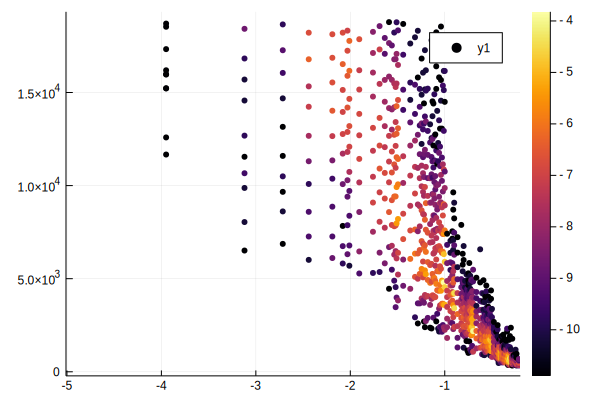

In [9]:
partitionplot(t, :carat => x -> -x, :price, stat = Hist(10))

- Any valid Plots keyword argument can also be included, such as changing the type of plot series to a barplot.

- Here we are essentially plotting `groupby(mean, t, :cut, select = :carat)`:

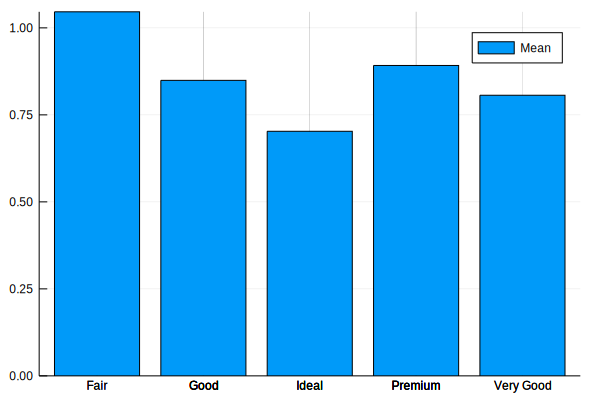

In [10]:
partitionplot(t, :cut, :carat; stat = Mean(), seriestype = :bar)

# `reduce` and `groupreduce`

- In the following examples, we'll see that the reducer for `reduce` and `groupreduce` can come from OnlineStats.  The OnlineStats reducers can be:
  1. A `Series`
  1. An `OnlineStat`
  1. A tuple of `OnlineStat`s


- Here we get the mean of `:carat` for each level of `:cut`:

In [11]:
groupreduce(Mean(), t, :cut; select = :carat)

Table with 5 rows, 2 columns:
cut          Mean
───────────────────────────────────────────
"Fair"       Mean: n=1610 | value=1.04614
"Good"       Mean: n=4906 | value=0.849185
"Ideal"      Mean: n=21551 | value=0.702837
"Premium"    Mean: n=13791 | value=0.891955
"Very Good"  Mean: n=12082 | value=0.806381

- We could also calculate the same information with `groupby`
- However `[group]reduce` with an OnlineStat is often more efficient.

In [12]:
@time groupreduce(Mean(), t, :cut; select = :carat)
@time groupby(mean, t, :cut; select = :carat)

  0.001051 seconds (246 allocations: 434.906 KiB)
  0.947968 seconds (596.38 k allocations: 26.474 MiB, 1.76% gc time)


Table with 5 rows, 2 columns:
cut          mean
─────────────────────
"Fair"       1.04614
"Good"       0.849185
"Ideal"      0.702837
"Premium"    0.891955
"Very Good"  0.806381

## Size of Selections

- One thing to note is that the selection in `reduce`/`groupreduce` must match the "input size" of the `OnlineStat` object passed as an argument.
- Different stats can be applied to different columns with the `Group` type.
    - Multiple stats of the same type can be created via integer multiplication (see example below)
- For example, if you want to calculate the means for 5 different columns, you would use as reducer:

In [13]:
5 * Mean()

Group
  ├── Mean: n=0 | value=0.0
  ├── Mean: n=0 | value=0.0
  ├── Mean: n=0 | value=0.0
  ├── Mean: n=0 | value=0.0
  └── Mean: n=0 | value=0.0

- In this example we create 3 histograms of 50 bins each to use the columns `:x`, `:y`, and `:z` as input:

In [14]:
hists = reduce(3Hist(50), t; select = (:x, :y, :z))

Group
  ├── Hist: AdaptiveBins
  ├── Hist: AdaptiveBins
  └── Hist: AdaptiveBins

- The printed histograms do not provide much information.  
- Fortunately, OnlineStats implements many Plots recipes.  
- Plotting a `Group` will then plot the stats it contains:

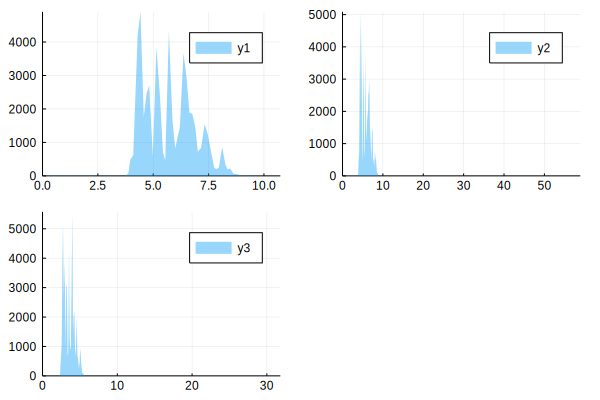

In [15]:
plot(hists, layout = 3)

- You may also want to calculate different statistics for different columns.

In [16]:
reducer = Group(Mean(), CountMap(String))

Group
  ├── Mean: n=0 | value=0.0
  └── CountMap: n=0 | value=DataStructures.OrderedDict{String,Int64}()

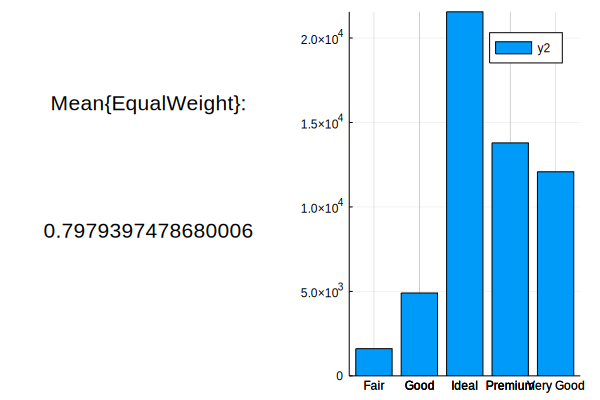

In [17]:
plot(reduce(reducer, t; select = (:carat, :cut)), layout = 2)

## Visualizing Continuous Distributions

- The `Hist` type is particularly useful for visualizing continuous distributions, as it adaptively finds the "best" bin locations.

- In the following cell, try increasing the number of bins and see how the histogram changes:

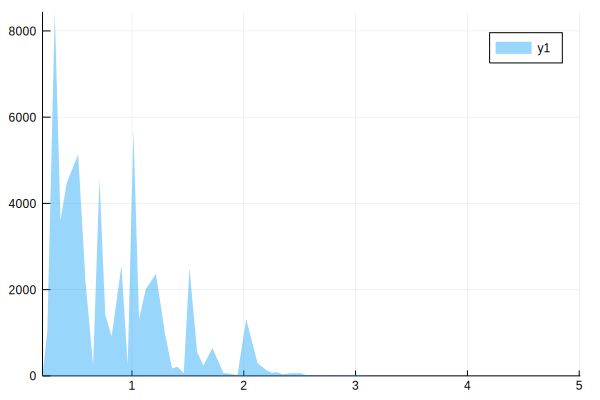

In [18]:
# try increasing the number of bins
plot(reduce(Hist(50), t; select = :carat))

## Visualizing Categorical Distributions

- The `CountMap` type tracks the number of occurrences for each unique value in a column. 
- `CountMap` accepts the column type as its argument.
- The `:cut` column is of type `String`, so here we use `CountMap(String)`:

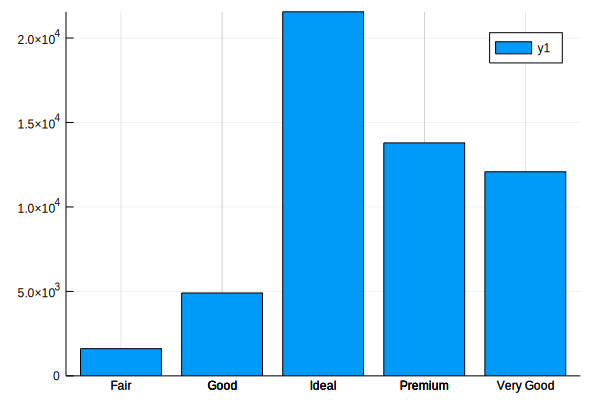

In [19]:
plot(reduce(CountMap(String), t; select = :cut))

## Mosaic Plot

- Mosaic plots are extremely useful in visualizing the association between two categorical variables, as it shows class probabilities of the `x` variables and conditional class probabilities of the `y` variable.  
- `Mosaic` accepts the two column types as its input.


- The `:cut` and `:color` variables are both of type `String`, so here we use `Mosiac(String, String)`.  
- We can see most common `:cut` is `"Ideal"` and the least common is `"Fair"` (which we already know from above).

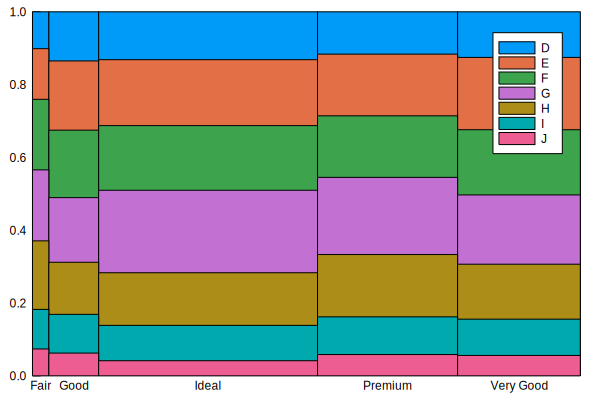

In [20]:
plot(reduce(Mosaic(String, String), t; select = (:cut, :color)))

# Statistical Models

- We can build linear (and ridge) regression models using the `LinRegBuilder` and `LinReg` types.

## `LinRegBuilder(p)`

- `LinRegBuilder` builds a data structure that allows you to regress any of the observed columns on any subset of other columns.

In [21]:
x = (:carat,:depth,:table,:price,:x,:y,:z)

o = reduce(LinRegBuilder(7), t; select = x)

LinRegBuilder of 7 variables

- If we wish to fit a model with formula:
```
price ~ carat + depth + table + x + y + z + 1
```
  We can specify the `y` variable to be the 4-th column, which was `:price`.  By default, an intercept (bias) term is included as the last coefficient.

In [22]:
coef(o; y=4, verbose=true)

Info: Regress 4 on [1, 2, 3, 5, 6, 7] with bias


7-element Array{Float64,1}:
 10686.3   
  -203.154 
  -102.446 
 -1315.67  
    66.3216
    41.6277
 20849.3   

- We can then create a different regression (without revisiting data) based on the formula

  ```
  carat ~ x + y + z
  ```

  by specifying the `y` and `x` variables and removing the `bias`:

In [23]:
coef(o; y=1, x = 5:7, bias = false)

3-element Array{Float64,1}:
  0.1764    
 -0.0311904 
  0.00663214

## `LinReg()`

- The `LinReg` type allows you to fit linear regression with an optional L2 (ridge) penalty.
- One thing to note is that besides `LinRegBuilder`, models in OnlineStats expect data as a tuple: `(x, y)`.
  - This requires selections to take the form: `((xvars...), yvar)`.
  

- In this example, we'll create the model:
```
carat ~ x + y + z
```
- Note that we found the same result as we did with `LinRegBuilder` above.

In [24]:
o = reduce(LinReg(), t; select = ((:x, :y, :z), :carat))

coef(o, 0.1)

3-element Array{Float64,1}:
 0.0857209
 0.0386171
 0.0400087

## Other Models

- **OnlineStats** has a variety of methods that are more advanced than linear regression.  
- They're beyond the scope of this introduction, but interested readers can investigate the following:

### `StatLearn` (Stochastic approximation for linear statistical learning models)

### `NBClassifier` (Naive Bayes Classifier)

### `FastTree`/ `FastForest` (experimental online decision trees/random forests)
